In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import skfuzzy as fuzz
import pandas as pd
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer
import prince

In [73]:
rfm_df = pd.read_csv('../datasets/Pakistan_Ecommerce/rfm.csv')
embedding_df = pd.read_csv('../datasets/Pakistan_Ecommerce/rfm_embedding.csv')

In [74]:
def get_pca_2d(df, predict):
    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
        n_components=3,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [75]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,1.0,0.027553,0.075592,-0.004154,0.032484,-0.018314,-0.041990,0.028784,0.015180,-0.008948,...,0.000961,-0.043752,-0.020272,0.007038,-0.007795,0.027966,-0.019098,0.039021,0.000568,0.019237
1,3.0,0.018404,0.060627,-0.004330,0.024581,-0.035879,-0.048666,-0.019052,0.029558,-0.016038,...,0.022971,-0.025133,-0.010234,0.003425,-0.010827,0.001008,0.012684,0.048591,-0.014719,0.017675
2,4.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
3,6.0,0.027553,0.075592,-0.004154,0.032484,-0.018314,-0.041990,0.028784,0.015180,-0.008948,...,0.000961,-0.043752,-0.020272,0.007038,-0.007795,0.027966,-0.019098,0.039021,0.000568,0.019237
4,7.0,0.025606,0.062882,-0.004133,0.034055,-0.027723,-0.046881,0.020611,0.019658,-0.014579,...,0.009746,-0.035312,-0.019050,0.008660,-0.008685,0.036232,-0.014210,0.048493,0.001722,0.020490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62285,115218.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62286,115267.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62287,115276.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839


In [76]:
rfm_df

,Customer ID,Recency,RecencyScore,RecencyScoreText,Frequency,FrequencyScore,FrequencyScoreText,MonetaryValue,MonetaryScore,MonetaryScoreText
0,1.0,789,1,a very long time ago,1,1,extremely rarely,1950.0,1,only a very little money
1,3.0,467,3,no so recently,4,1,extremely rarely,1245.0,1,only a very little money
2,4.0,2,5,very recently,261,1,extremely rarely,1445579.0,1,only a very little money
3,6.0,789,1,a very long time ago,1,1,extremely rarely,170.0,1,only a very little money
4,7.0,501,2,some time ago,4,1,extremely rarely,1939.0,1,only a very little money
...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,4,5,very recently,3,1,extremely rarely,9029.0,1,only a very little money
62285,115218.0,3,5,very recently,1,1,extremely rarely,600.0,1,only a very little money
62286,115267.0,2,5,very recently,3,1,extremely rarely,1397.0,1,only a very little money
62287,115276.0,2,5,very recently,2,1,extremely rarely,3749.0,1,only a very little money


Outliers

In [77]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

# Unsupervised Outlier Detection Using Empirical Cumulative Distribution Functions (ECOD)
clf = ECOD()
clf.fit(embedding_df.iloc[:, 1:])

out = clf.predict(embedding_df.iloc[:, 1:]) 
embedding_df["outliers"] = out
rfm_df["outliers"] = out

df_embedding_no_out = embedding_df[embedding_df["outliers"] == 0]
df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)
rfm_df_no_out = rfm_df[rfm_df["outliers"] == 0]
rfm_df_no_out = rfm_df_no_out.drop(["outliers"], axis = 1)

df_embedding_with_out = embedding_df.copy()
df_embedding_with_out = df_embedding_with_out.drop(["outliers"], axis = 1)
rfm_df_with_out = rfm_df.copy()
rfm_df_with_out = rfm_df_with_out.drop(["outliers"], axis = 1)

In [78]:
df_embedding_with_out.shape

(62289, 769)

In [79]:
df_embedding_with_out

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,1.0,0.027553,0.075592,-0.004154,0.032484,-0.018314,-0.041990,0.028784,0.015180,-0.008948,...,0.000961,-0.043752,-0.020272,0.007038,-0.007795,0.027966,-0.019098,0.039021,0.000568,0.019237
1,3.0,0.018404,0.060627,-0.004330,0.024581,-0.035879,-0.048666,-0.019052,0.029558,-0.016038,...,0.022971,-0.025133,-0.010234,0.003425,-0.010827,0.001008,0.012684,0.048591,-0.014719,0.017675
2,4.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
3,6.0,0.027553,0.075592,-0.004154,0.032484,-0.018314,-0.041990,0.028784,0.015180,-0.008948,...,0.000961,-0.043752,-0.020272,0.007038,-0.007795,0.027966,-0.019098,0.039021,0.000568,0.019237
4,7.0,0.025606,0.062882,-0.004133,0.034055,-0.027723,-0.046881,0.020611,0.019658,-0.014579,...,0.009746,-0.035312,-0.019050,0.008660,-0.008685,0.036232,-0.014210,0.048493,0.001722,0.020490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62284,115200.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62285,115218.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62286,115267.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839
62287,115276.0,0.018136,0.050329,-0.004303,0.025111,-0.040579,-0.053548,-0.021425,0.033152,-0.035411,...,0.017286,-0.025220,0.000143,0.012129,-0.008145,0.012198,-0.001923,0.053937,-0.011559,0.017839


In [80]:
n_clusters = 4

In [81]:
from fcmeans import FCM
rfm_array = df_embedding_no_out.iloc[:, 1:].to_numpy()

fcm = FCM(n_clusters=n_clusters)
fcm.fit(rfm_array)

fcm_centers = fcm.centers
fcm_labels  = fcm.predict(rfm_array)

fcm_centers


array([[ 0.01840424,  0.06062661, -0.00432986, ...,  0.04859121,
        -0.01471893,  0.01767504],
       [ 0.02560581,  0.0628824 , -0.00413342, ...,  0.04849273,
         0.00172191,  0.02049018],
       [ 0.02140267,  0.04747096, -0.00437084, ...,  0.05606271,
        -0.01044107,  0.0173926 ],
       [ 0.02755283,  0.07559218, -0.00415416, ...,  0.039021  ,
         0.00056848,  0.01923671]])

In [82]:
np.unique(fcm_labels)

array([0, 1, 2, 3], dtype=int64)

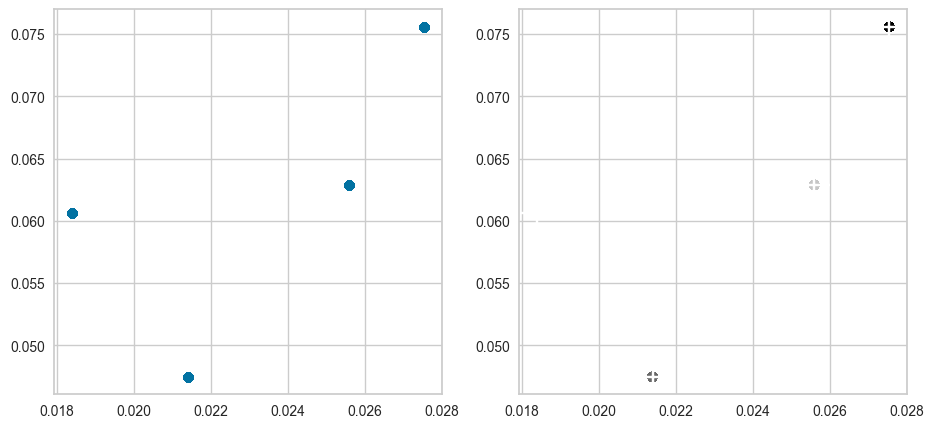

In [83]:
# plot the results
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(rfm_array[:,0], rfm_array[:,1], alpha=.1)
axes[1].scatter(rfm_array[:,0], rfm_array[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
plt.show()

In [84]:
n_clusters_list = [2, 3, 4]
models = list()
for n_clusters in n_clusters_list:
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(rfm_array)
    models.append(fcm)

n_clusters = 2, PC = 0.414, PEC = 0.217, Silhouette = 0.692, Calinski = 138207.850, Davies = 0.657, Inertia = 894.033
n_clusters = 3, PC = 0.286, PEC = 0.133, Silhouette = 0.811, Calinski = 180062.760, Davies = 0.331, Inertia = 894.033
n_clusters = 4, PC = 0.250, PEC = 0.000, Silhouette = 1.000, Calinski = 456509261287581664800808275804160.000, Davies = 0.000, Inertia = 429.381


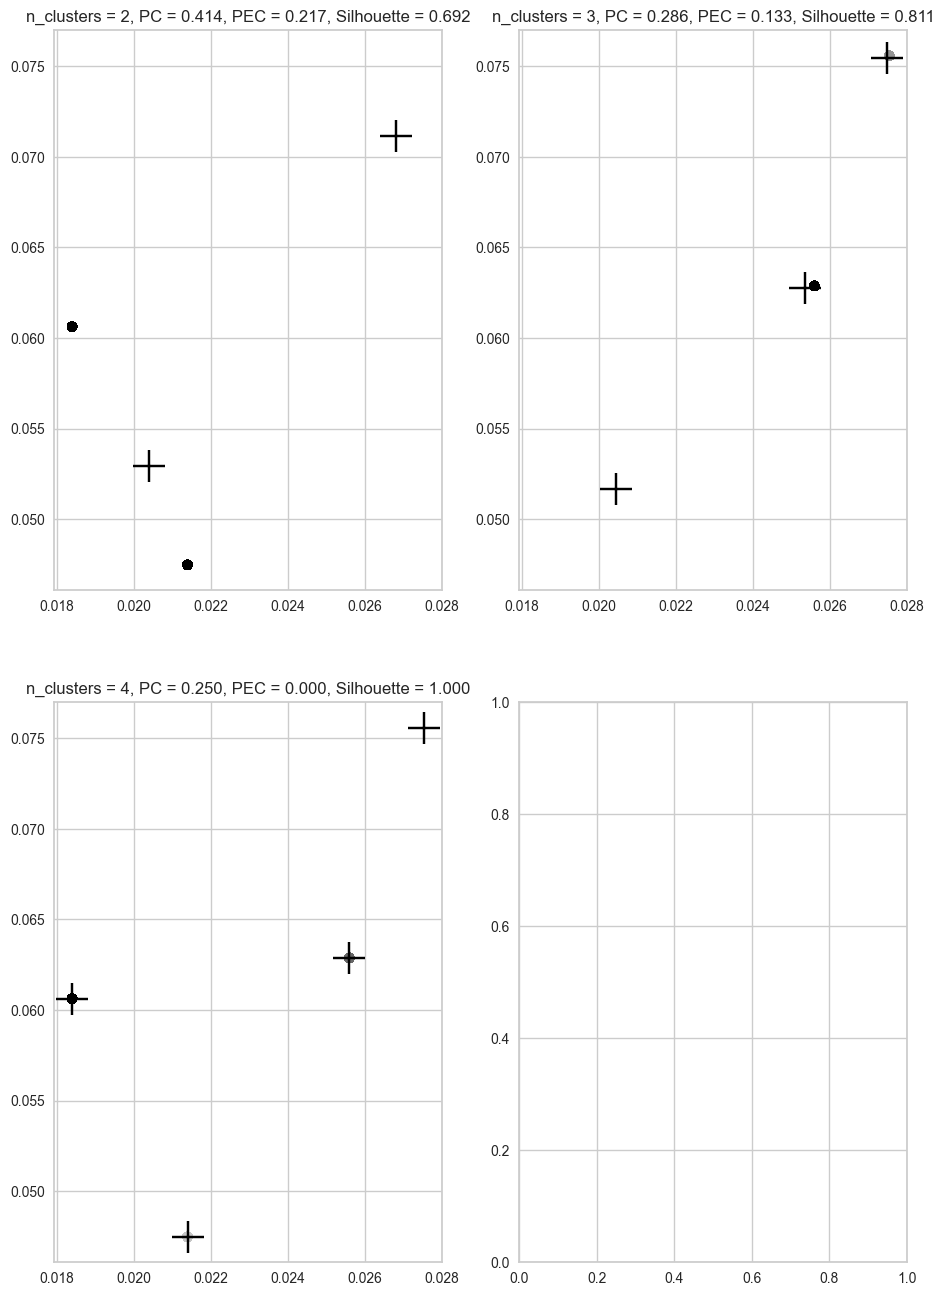

In [87]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# outputs
num_clusters = len(n_clusters_list)
rows = int(np.ceil(np.sqrt(num_clusters)))
cols = int(np.ceil(num_clusters / rows))

f, axes = plt.subplots(rows, cols, figsize=(11,16))
for n_clusters, model, axe in zip(n_clusters_list, models, axes.ravel()):
    # get validation metrics
    pc = model.partition_coefficient
    pec = model.partition_entropy_coefficient
    silhouette = silhouette_score(rfm_array, model.predict(rfm_array))
    calsinki = calinski_harabasz_score(rfm_array, model.predict(rfm_array))
    davies = davies_bouldin_score(rfm_array, model.predict(rfm_array))
    inertia = 0
    for i, center in enumerate(fcm_centers):
        # Get points in this cluster
        cluster_points = rfm_array[fcm_labels == i]
        # Calculate distance of each point from the center
        distances = np.linalg.norm(cluster_points - center, axis=1)
        # Add squared distances to inertia
        inertia += np.sum(distances**2)
    print(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, Silhouette = {silhouette:.3f}, Calinski = {calsinki:.3f}, Davies = {davies:.3f}, Inertia = {inertia:.3f}')
    
    fcm_centers = model.centers
    fcm_labels = model.predict(rfm_array)
    # plot result
    axe.scatter(rfm_array[:,0], rfm_array[:,1], c=fcm_labels, alpha=.1)
    axe.scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='black')
    axe.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}, Silhouette = {silhouette:.3f}')
plt.show()

In [70]:
rfm_df_no_out

,Customer ID,Recency,RecencyScore,RecencyScoreText,Frequency,FrequencyScore,FrequencyScoreText,MonetaryValue,MonetaryScore,MonetaryScoreText
0,1.0,789,1,a very long time ago,1,1,extremely rarely,1950.0,1,only a very little money
1,3.0,467,3,no so recently,4,1,extremely rarely,1245.0,1,only a very little money
3,6.0,789,1,a very long time ago,1,1,extremely rarely,170.0,1,only a very little money
4,7.0,501,2,some time ago,4,1,extremely rarely,1939.0,1,only a very little money
5,9.0,789,1,a very long time ago,1,1,extremely rarely,5500.0,1,only a very little money
...,...,...,...,...,...,...,...,...,...,...
61332,97429.0,159,4,recently,5,1,extremely rarely,21877.0,1,only a very little money
61333,97439.0,159,4,recently,1,1,extremely rarely,4733.0,1,only a very little money
61334,97458.0,159,4,recently,6,1,extremely rarely,3509.0,1,only a very little money
61339,97515.0,159,4,recently,1,1,extremely rarely,15833.0,1,only a very little money


In [71]:
# average the RFM values of the clusters to get the general characteristics of the relevant customer segments
rfm_df_no_out["cluster"] = fcm_labels
grouped_df = rfm_df_no_out.groupby("cluster").agg({"Recency": "mean", "Frequency": "mean", "MonetaryValue": "mean"})
grouped_df

,Recency,Frequency,MonetaryValue
cluster,,,
0,674.466315,1.910774,4800.872410
1,273.158164,4.845371,25694.943181
2,406.511616,3.978340,8655.739867
3,547.859280,2.873218,7615.170880


IndexError: list index out of range

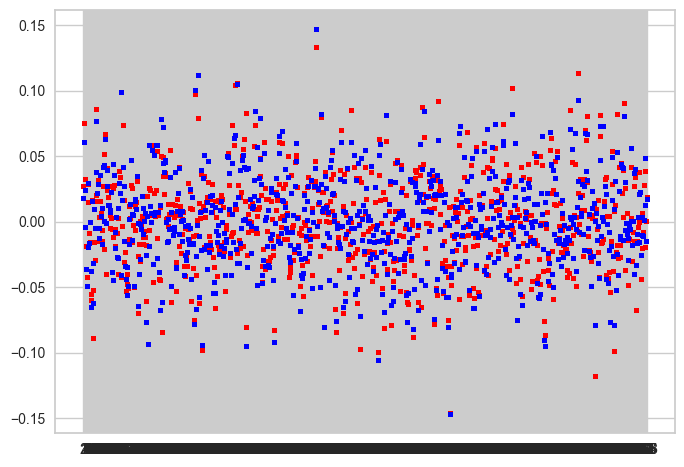

In [18]:
from skfuzzy import cluster
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Define the colors for each cluster

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_embedding_no_out.iloc[:, 1:].T, n_clusters, 2, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

# Plotting the results
fig1, ax1 = plt.subplots()
for j in range(n_clusters):
    ax1.plot(df_embedding_no_out.iloc[:, 1:][cluster_membership == j].T, '.',
             color=colors[j])
    
ax1.set_title('Trained model')
plt.show()


IndexError: list index out of range

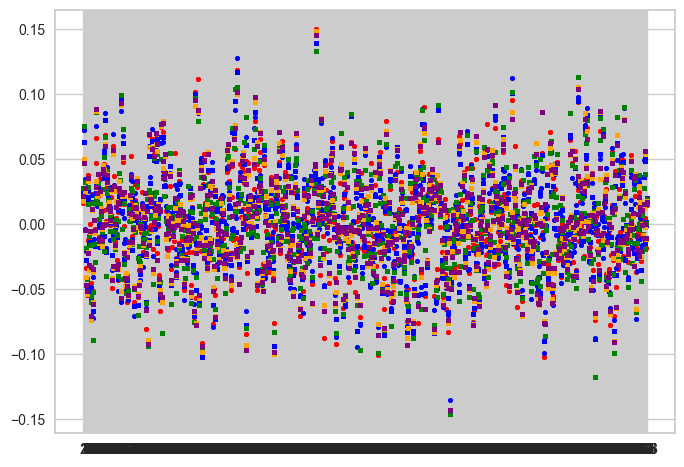

In [21]:
from skfuzzy import cluster
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Define the colors for each cluster

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_embedding_with_out.iloc[:, 1:].T, n_clusters, 2, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

# Plotting the results
fig1, ax1 = plt.subplots()
for j in range(n_clusters):
    ax1.plot(df_embedding_with_out.iloc[:, 1:][cluster_membership == j].T, '.',
             color=colors[j])
    
ax1.set_title('Trained model')
plt.show()


In [88]:
# evaluate the model
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

silhouette_score(df_embedding_with_out.iloc[:, 1:], cluster_membership, metric='euclidean')



0.9997930385694415

In [ ]:
# partition_coefficient


IndexError: list index out of range

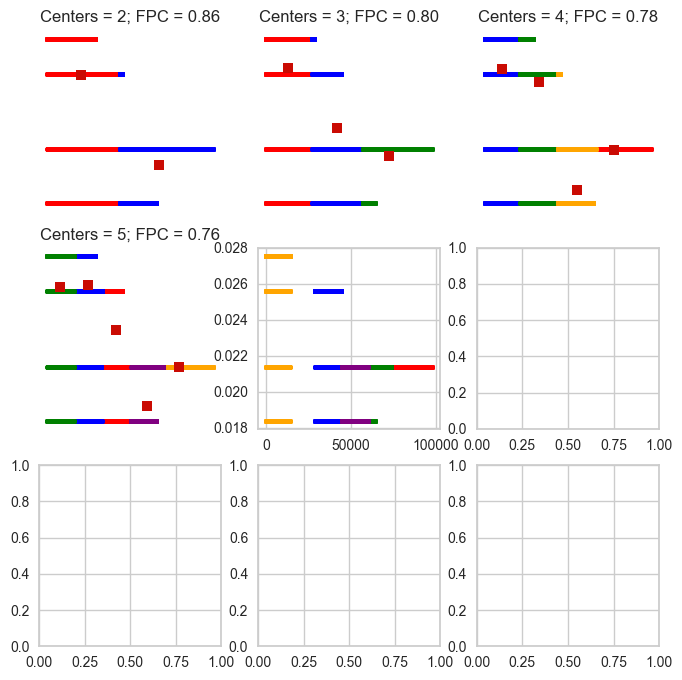

In [16]:
import skfuzzy as fuzz

# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = df_embedding_no_out.values.T
fpcs = []
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Define the colors for each cluster

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None
    )

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(
            alldata[0, cluster_membership == j],
            alldata[1, cluster_membership == j],
            ".",
            color=colors[j],
        )

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], "rs")

    ax.set_title("Centers = {0}; FPC = {1:.2f}".format(ncenters, fpc))
    ax.axis("off")
    
fig1.tight_layout()

# Plot the result of the fuzzy c-means clustering, which shows
# three clusters along with the c-means centers.
fig2, ax2 = plt.subplots(figsize=(8, 8))

ax2.plot(fpcs, color="black")
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")


plt.show()
